## Problem Statement:

### The rise of social media has led to an increase in the spread of misinformation, particularly during natural disasters and emergencies. Inaccurate or fake news can lead to panic, fear, and confusion, hindering rescue and relief efforts. Therefore, there is a need to accurately classify tweets related to disasters as real or fake to prevent the spread of false information. This task is challenging as tweets are often brief, unstructured, and contain a mix of factual and emotional language. Developing an effective machine learning model to classify real and fake disaster tweets can help mitigate the negative impact of false information on the public and emergency responders.

### The dataset is from Kaggle where we have 7503 values or rows in training set and 3243 rows in test set and test set does not have target column. Dataset is about Disaster tweets and we will be classifying fake and real tweets

[Data](https://www.kaggle.com/c/nlp-getting-started/data?select=train.csv)

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
import spacy
import nltk
import networkx as nx
from gensim.models import word2vec

import warnings
warnings.filterwarnings('ignore')

In [71]:
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
print(df.head(3))

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   

   target  
0       1  
1       1  
2       1  


In [3]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
df1 = df.copy()

In [5]:
#looking at out text variable
df['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [6]:
print(df_test.shape)
print(df.shape)

(3263, 4)
(7613, 5)


In [7]:
## Checking for missing values
print(df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [8]:
## Checking for missing values in test data
print(df_test.isnull().sum())

id             0
keyword       26
location    1105
text           0
dtype: int64


In [9]:
#Checking the percentage of missing values
round(100 * (df.isnull().sum()/len(df)),2)

id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64

#### We will be classifying the tweets based on the train test and use that model on the test data

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [11]:
df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

#### It appears that the location variable has places around the world and may not have much significance in classifyin the tweets

In [12]:
## Dropping location from both test and train data
df.drop('location', axis =1,inplace = True)
df_test.drop('location',axis = 1,  inplace = True)

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/krishnadevabhaktuni/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Using regular expressions to clean the data below

In [14]:
## Applying Regex to remove punctuation, hyperlinks and numbers
## Converting text to lower 
## Applying Lemmatizer to stemming and get the meaninful words
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(df)):
    #review = re.sub(r'^https?:\/\/.*[\r\n]*', '', df['text'][i], flags=re.MULTILINE)
    #review = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', df['text'][i], flags=re.MULTILINE)
    review = re.sub(r"http\S+", "", df['text'][i]) # This code removes links from text
    review = re.sub('[^a-zA-Z\d+]', ' ', review) 
    # this code is removing all non-alphanumeric characters (except for +) and replace them with one space
    review = re.sub('[0-9]', '', review) #removing all numbers
    review = review.lower()
    review = review.split()
    #review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = [lemmatizer.lemmatize(word, pos = 'v') for word in review if not word in stopwords.words('english')]
    #pos part of speech = 'verb'
    review = [lemmatizer.lemmatize(word, pos = 'n') for word in review] # n for noun
    review = [lemmatizer.lemmatize(word, pos = 'a') for word in review] #a for adjective
    review = ' '.join(review)
    corpus.append(review)

#### Decided to not use porter stemmer as stemming leads to incorret meaning of a word

In [15]:
corpus[0]

'deed reason earthquake may allah forgive u'

In [16]:
print(df.shape)
df['text'].apply(lambda x: len(x.split(' '))).sum()

(7613, 4)


113654

#### We can see above that we have 113,654 words in our train data 

In [17]:
## Applying the same for test dataset
lemmatizer = WordNetLemmatizer()
corpus_test = []
for i in range(0, len(df_test)):
    review = re.sub(r"http\S+", "", df_test['text'][i])
    review = re.sub('[^a-zA-Z\d+]', ' ', review)
    review = re.sub('[0-9]', '', review)
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word, pos = 'v') for word in review if not word in stopwords.words('english')]
    review = [lemmatizer.lemmatize(word, pos = 'n') for word in review]
    review = [lemmatizer.lemmatize(word, pos = 'a') for word in review]
    review = ' '.join(review)
    corpus_test.append(review)

In [18]:
corpus_test[1:4]

['hear earthquake different city stay safe everyone',
 'forest fire spot pond goose flee across street cannot save',
 'apocalypse light spokane wildfire']

In [19]:
corpus[1:4]

['forest fire near la ronge sask canada',
 'resident ask shelter place notify officer evacuation shelter place order expect',
 'people receive wildfire evacuation order california']

#### We can see that the data is clean from the above two cells in both training and test data

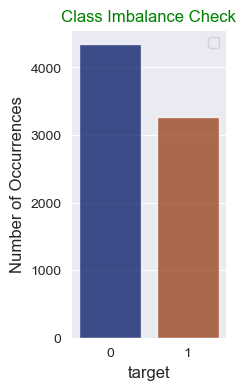

In [78]:
## Before proceeding to model, checking for class imbalance
sns.set_style('darkgrid')
classes = df['target'].value_counts()
plt.figure(figsize=(2,4))
sns.barplot(classes.index, classes.values, alpha=0.8, palette = 'dark')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('target', fontsize=12)
plt.title("Class Imbalance Check", color = 'Green')
plt.legend('0', '1')
plt.savefig('../images/imbalance')
plt.show();

### Baseline Calculation

In [76]:
df['target'].value_counts(normalize = True) *100

0    57.034021
1    42.965979
Name: target, dtype: float64

### We do not have a class imbalance in our dataset and we have around 57% of fake tweets and 43% of real tweets

In [22]:
## Creating a Dictionary to see most frequent words
wordfreq = {}
for sentence in corpus:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [23]:
## Using heap module in python to see 10 most frequent words
import heapq
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)
most_freq[0:10]

['get', 'like', 'fire', 'amp', 'go', 'u', 'bomb', 'new', 'via', 'one']

In [24]:
## create features for Bag of words
sentence_vectors = []
for sentence in corpus:
    sentence_tokens = nltk.word_tokenize(sentence)
    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)
sentence_vectors = np.asarray(sentence_vectors)

In [25]:
sentence_vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [48]:
nlp = spacy.load('en_core_web_sm')
text_doc = nlp('text')

In [49]:
tweet_tokenizer = TweetTokenizer()
tokens1 = []
for sent in corpus:
    for word in tweet_tokenizer.tokenize(sent):
        if len(word) < 2:
            continue
        tokens1.append(word.lower())

In [50]:
print("The number of tokens we have in our training dataset are {}" .format(len(tokens1)))

The number of tokens we have in our training dataset are 68619


In [51]:
## Creating tokens using TweetTokenizer from NLTK library
tweet_tokenizer = TweetTokenizer()
tweet_tokens = []
for sent in corpus:
    review2 = tweet_tokenizer.tokenize(sent)
    tweet_tokens.append(review2)

In [52]:
tweet_tokens[1]

['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']

In [53]:
## Removing punctuation, numbers and hyperlinks from the text
corpus1 = []
for i in range(0, len(df)):
    review1 = re.sub(r"http\S+", "", df['text'][i])
    review1 = re.sub('[^a-zA-Z\d+]', ' ', review1)
    review1 = review1.split()
    review1 = ' '.join(review1)
    corpus1.append(review1)

In [54]:
## Language Parsing using spacy
nlp = spacy.load('en_core_web_sm')
corpus_spacy = []
for i in corpus1:
    text_doc = nlp(i)
    corpus_spacy.append(text_doc)

In [68]:
from collections import Counter
# Utility function to calculate how frequently words appear in the text.
def word_frequencies(corpus_spacy, include_stop = False):
    
    # Build a list of words.
    # Strip out punctuation and, optionally, stop words.
    words = []
    for token in corpus_spacy:
        for j in token:
            if not j.is_punct and (not j.is_stop and not include_stop):
                words.append(j.text)
            
    # Build and return a Counter object containing word counts.
    return Counter(words)

In [69]:
corpus_freq = word_frequencies(corpus_spacy).most_common(30)
print('corpus_spacy includes stop words:', corpus_freq)

corpus_spacy includes stop words: [('s', 893), ('t', 495), ('amp', 344), ('like', 324), ('m', 311), ('2', 222), ('fire', 177), ('people', 167), ('3', 148), ('don', 147), ('1', 122), ('S', 118), ('California', 117), ('got', 114), ('News', 114), ('RT', 110), ('5', 109), ('new', 107), ('disaster', 106), ('New', 105), ('know', 104), ('video', 103), ('4', 101), ('day', 99), ('time', 98), ('buildings', 97), ('going', 95), ('killed', 93), ('YouTube', 92), ('burning', 92)]


In [57]:
corpus4 = ' '.join(corpus)

In [58]:
model = word2vec.Word2Vec(
    tweet_tokens,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=50,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    #size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [79]:
# Find most positive similar words to life
print(model.wv.most_similar(positive = ['life']))

[('leave', 0.9927443265914917), ('happen', 0.9925126433372498), ('want', 0.989604651927948), ('right', 0.9889990091323853), ('know', 0.9875696301460266), ('man', 0.9856347441673279), ('need', 0.984383761882782), ('accident', 0.9835615158081055), ('car', 0.9827168583869934), ('shit', 0.9821823239326477)]


In [80]:
# Find most negative similar words to life
print(model.wv.most_similar(negative = ['life']))

[('bomber', -0.3167777955532074), ('legionnaire', -0.33659183979034424), ('detonate', -0.34817418456077576), ('gt', -0.3524169921875), ('suicide', -0.4031323194503784), ('atomic', -0.4097940921783447), ('content', -0.4500056207180023), ('northern', -0.4633386731147766), ('typhoon', -0.49775663018226624), ('army', -0.4979211390018463)]


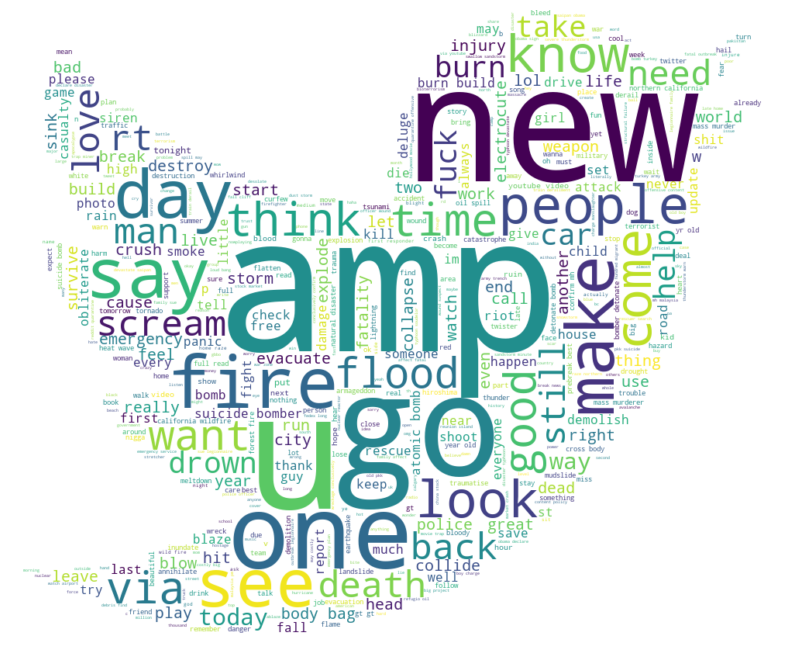

In [61]:
## Creating wordcloud for visualizing most important words
from PIL import Image
wc_text = corpus4
custom_mask = np.array(Image.open('../images/twitter_mask.png'))

wc = WordCloud(background_color = 'white', max_words = 500, mask = custom_mask, height = 
              5000, width = 5000)
wc.generate(wc_text)
image_colors = ImageColorGenerator(custom_mask)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### We can see frequent words like amp, fire, death, scream in big letters in the wordcloud image above and less frequent words in small letters